In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
def generate_time_series(m, n_seq):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4,m,1)
    time = np.linspace(0, 1, n_seq)
    series = 0.5 *np.cos((time-offsets1) * (freq1 * 10 + 10))
    series += 0.3 *np.sin((time-offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(m, n_seq)-0.5)
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(1)
n_seq = 30
n_pred = 10

series = generate_time_series(5000, n_seq+n_pred)
series.shape

(5000, 40, 1)

In [4]:
x_train = series[:3000, :n_seq]
x_valid = series[3000:4000, :n_seq]
x_test = series[4000:,:n_seq]

In [7]:
y = np.empty((5000, n_seq, n_pred))

for step_ahead in range(1, n_pred+1):
    y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_seq,0]

y_train = y[:3000]
y_valid = y[3000:4000]
y_test = y[4000:]

In [8]:
x_train.shape, y_train.shape

((3000, 30, 1), (3000, 30, 10))

In [9]:
def plot_seq(x, y, y_pred=None):
    plt.plot(x, '.-')
    n_seq = x.shape[0]
    ahead = y.shape[0]
    plt.plot(np.arange(n_seq, n_seq+ahead), y, 'go-', label='$y$')
    if y_pred is not None:
        plt.plot(np.arange(n_seq, n_seq+ahead), y_pred, 'rx-',
                label='$\hat y$', markersize=10)
    plt.hlines(0, 0, n_seq + ahead, linewidth = 1)
    plt.axis([0, n_seq +ahead, -1, 1])
    plt.grid(True)
    plt.legend(fontsize=14)

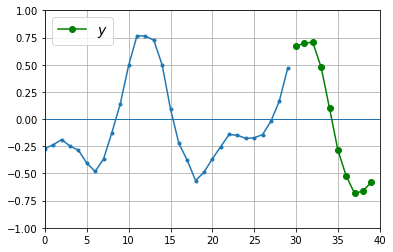

In [10]:
plot_seq(x_test[0,:,0], y_test[0,-1])

In [11]:
np.random.seed(1)
tf.random.set_seed(1)

In [12]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          1760      
                                                                 
 lstm_1 (LSTM)               (None, None, 20)          3280      
                                                                 
 time_distributed (TimeDistr  (None, None, 10)         210       
 ibuted)                                                         
                                                                 
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


In [15]:
def last_time_step_mse(y_true, y_pred):
    return keras.metrics.mean_squared_error(y_true[:,-1],y_pred[:,-1])

model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01),
             metrics=[last_time_step_mse])

In [16]:
train = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
94/94 [==============================] - 9s 47ms/step - loss: 0.1001 - last_time_step_mse: 0.0880 - val_loss: 0.0711 - val_last_time_step_mse: 0.0484
Epoch 2/20
94/94 [==============================] - 3s 28ms/step - loss: 0.0647 - last_time_step_mse: 0.0400 - val_loss: 0.0603 - val_last_time_step_mse: 0.0354
Epoch 3/20
94/94 [==============================] - 2s 21ms/step - loss: 0.0571 - last_time_step_mse: 0.0307 - val_loss: 0.0554 - val_last_time_step_mse: 0.0272
Epoch 4/20
94/94 [==============================] - 2s 20ms/step - loss: 0.0541 - last_time_step_mse: 0.0282 - val_loss: 0.0529 - val_last_time_step_mse: 0.0253
Epoch 5/20
94/94 [==============================] - 2s 21ms/step - loss: 0.0478 - last_time_step_mse: 0.0196 - val_loss: 0.0431 - val_last_time_step_mse: 0.0148
Epoch 6/20
94/94 [==============================] - 2s 21ms/step - loss: 0.0417 - last_time_step_mse: 0.0135 - val_loss: 0.0390 - val_last_time_step_mse: 0.0124
Epoch 7/20
94/94 [================

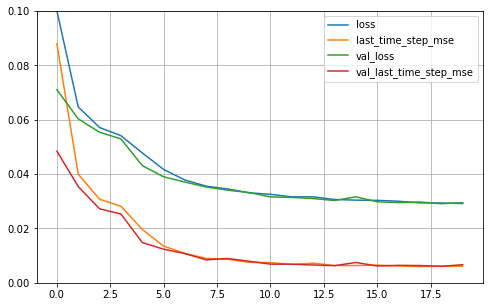

In [18]:
pd.DataFrame(train.history).plot(figsize=(8,5))
plt.grid(True)
plt.ylim(0,0.1)
plt.show()

In [20]:
model.evaluate(x_test,y_test)

32/32 [==============================] - 0s 6ms/step - loss: 0.0295 - last_time_step_mse: 0.0063


[0.029489973559975624, 0.006288628559559584]

In [21]:
y_pred = model.predict(x_test)

32/32 [==============================] - 1s 6ms/step


In [22]:
y_test.shape, y_pred.shape

((1000, 30, 10), (1000, 30, 10))

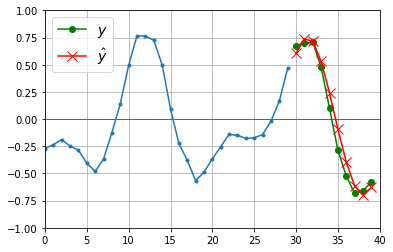

In [23]:
i = 0
plot_seq(x_test[i, :,0], y_test[i,-1], y_pred[i,-1])